## Regresor

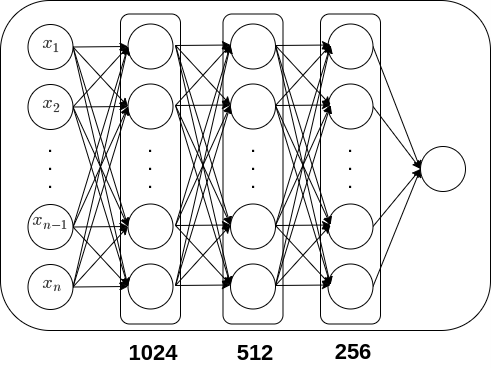

In [1]:
#Librerías
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from time import time

%store -r

2023-03-29 13:41:25.420458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-29 13:41:25.700634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Para leer los datos
data_file = "../BasesDeDatos/CaractFCM.csv"
df = pl.read_csv(data_file, dtypes=[pl.Float64], has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_B2B = df[0:987, :]
# Datos con fibra óptica a 0dBm
df_fiber_0 = df[988:1520, :]
# Datos con fibra óptica a 9dBm
df_fiber_9 = df[1521:, :]

In [3]:
def estimation_model(input_dim, layers_props_lst):
    model = ker.Sequential()
    # Capas ocultas
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regresor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    # Compilar modelo
    model.compile(loss="mean_absolute_error", optimizer="adam")

    return model


def crossvalidation(X, y, n_splits, layer_props, callbacks):
    # Para calcular el tiempo que tarda
    t0 = time()

    # Diccionario donde se almacenarán los puntajes
    scores = {}
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    scores["rmse"] = {"train": [], "test": []}
    
    # Se hace un K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estandarización de las variables de entrada
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props)
        # Guardar la pérdida escalar de prueba (Test scalar loss)
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Iteraciones necesarias: {len(loss.history['loss'])}")
        
        # Se predice con los datos de entrenamiento
        predictions_train = model.predict(X_train)
        # Se predice con los datos de prueba
        predictions_test = model.predict(X_test_kf)

        # Se crea un dataframe con los resultados para visualizarlos mejor
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Cálculo del MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Cálculo de R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
         
        # Cálculo de RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )

        # Anexo a las listas
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        
    print(f"Tiempo transcurrido: {(time() - t0)/60:.2f} minutos")

    return scores


def test_model(data, n_splits, max_neurons, activations):
    """ Probar un modelo con parámetros establecidos. """
    variables = 17

    # Separando variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Etiquetas
    y = np.array(data[:, 19:20]).T
    
    # Propiedades de las capas
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=300, mode="min", restore_best_weights=True)
    ]
    
    return crossvalidation(X, y, n_splits, layer_props, callbacks)


def smooth_line(x, y):
    x_smooth = np.linspace(x[0], x[-1], 1000)
    bspline = sp.interpolate.make_interp_spline(x, y)
    y_smooth = bspline(x_smooth)

    return x_smooth, y_smooth


def plot_scores(scores, max_neurons):
    score_names = ["mae", "r2", "rmse"]
    markers = ["*", "x", "^", "+"]
    data_type = ["train", "test"]
    
    plt.figure(figsize=(16, 4*len(scores)))
    
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(3, 2, i + 1)
            for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], label=f"max. n. = {neurons}, µ = {np.mean(points):.4f}",
                            s = 100)
                
            plt.title(f"Datos de {'entrenamiento' if dt == 'train' else 'prueba'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1


def calc_once(varname, fn, args):
    """ Calcular una variable una sola vez. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

## Crosvalidación para B2B variando el número de neuronas por capa

In [4]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_1024_B2B = calc_once("scores_1024_B2B", test_model, args)

In [5]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_512_B2B = calc_once("scores_512_B2B", test_model, args)

In [6]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_256_B2B = calc_once("scores_256_B2B", test_model, args)

In [7]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_128_B2B = calc_once("scores_128_B2B", test_model, args)

In [8]:
%store scores_1024_B2B scores_512_B2B scores_256_B2B scores_128_B2B

Stored 'scores_1024_B2B' (dict)
Stored 'scores_512_B2B' (dict)
Stored 'scores_256_B2B' (dict)
Stored 'scores_128_B2B' (dict)


### Gráficas de puntajes

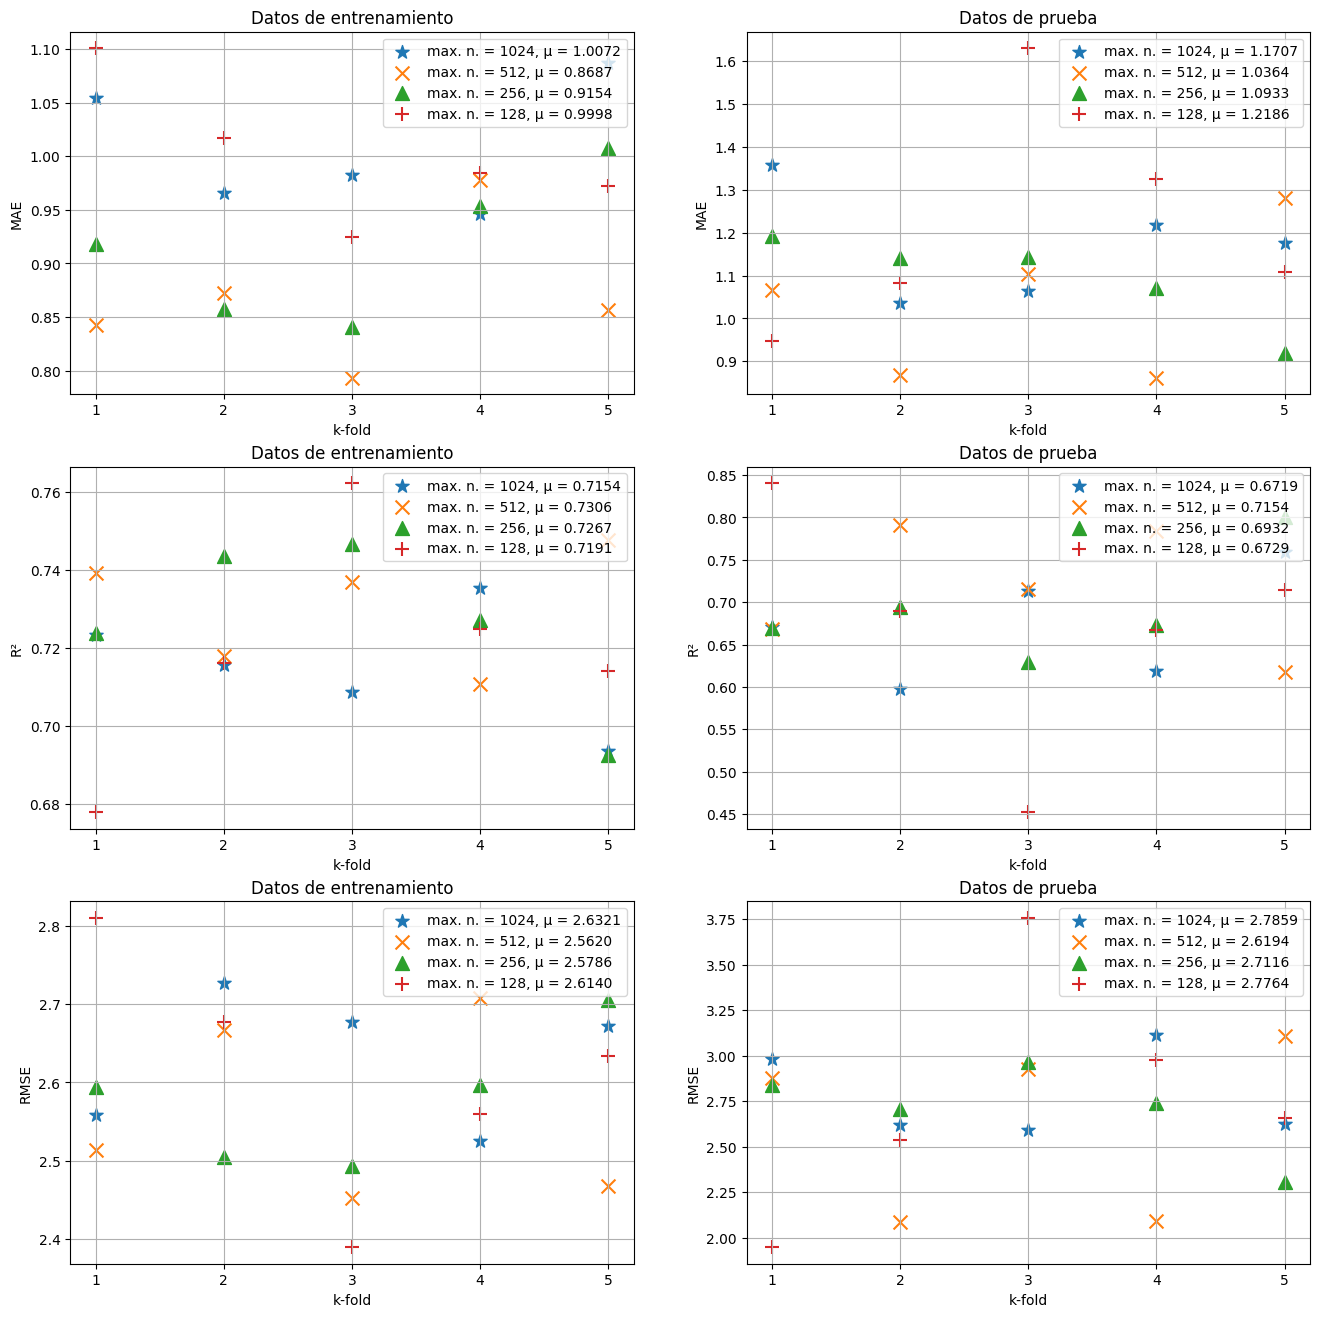

In [9]:
scores = [scores_1024_B2B, scores_512_B2B, scores_256_B2B, scores_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Crosvalidación para fibra óptica a 0dBm variando el número de neuronas por capa

In [10]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_1024_fiber_0 = calc_once("scores_1024_fiber_0", test_model, args)

In [11]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_512_fiber_0 = calc_once("scores_512_fiber_0", test_model, args)

In [12]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_256_fiber_0 = calc_once("scores_256_fiber_0", test_model, args)

In [13]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_128_fiber_0 = calc_once("scores_128_fiber_0", test_model, args)

In [14]:
%store scores_1024_fiber_0 scores_512_fiber_0 scores_256_fiber_0 scores_128_fiber_0

Stored 'scores_1024_fiber_0' (dict)
Stored 'scores_512_fiber_0' (dict)
Stored 'scores_256_fiber_0' (dict)
Stored 'scores_128_fiber_0' (dict)


## Gráficas de puntajes

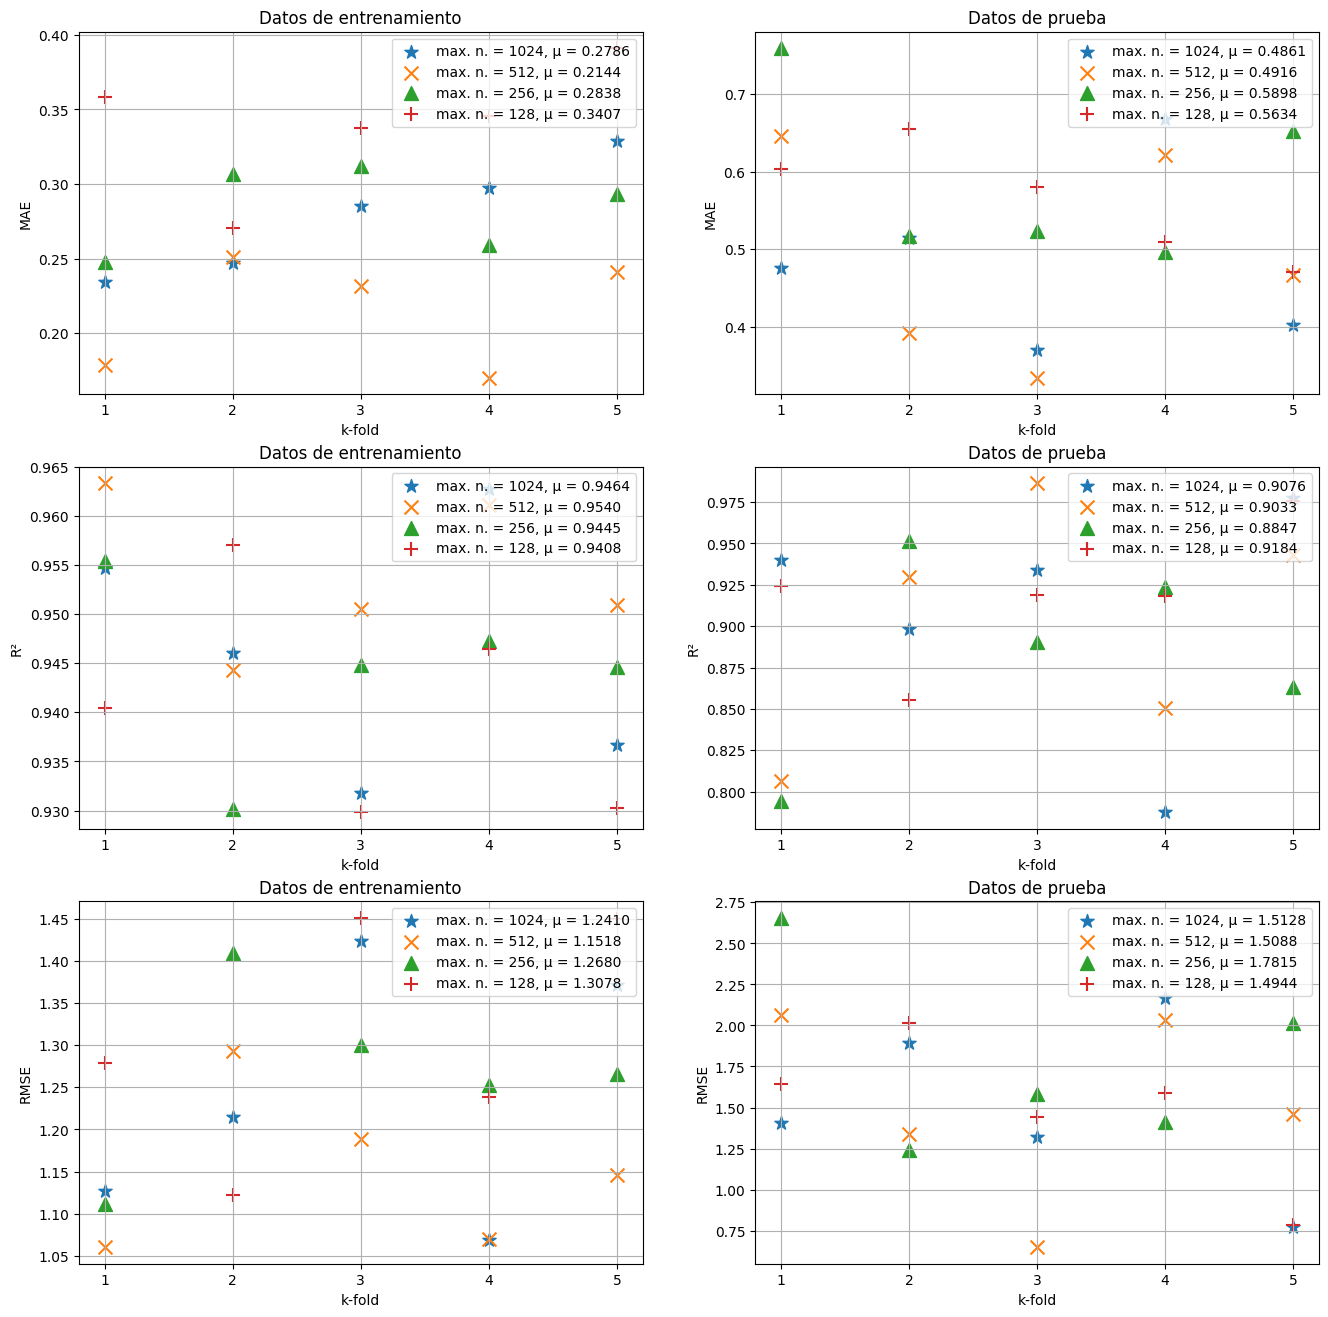

In [15]:
scores = [scores_1024_fiber_0, scores_512_fiber_0, scores_256_fiber_0, scores_128_fiber_0]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Crosvalidación para fibra óptica a 9dBm variando el número de neuronas por capa

In [16]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_1024_fiber_9 = calc_once("scores_1024_fiber_9", test_model, args)

In [17]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_512_fiber_9 = calc_once("scores_512_fiber_9", test_model, args)

In [18]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_256_fiber_9 = calc_once("scores_256_fiber_9", test_model, args)

In [19]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_128_fiber_9 = calc_once("scores_128_fiber_9", test_model, args)

In [20]:
%store scores_1024_fiber_9 scores_512_fiber_9 scores_256_fiber_9 scores_128_fiber_9

Stored 'scores_1024_fiber_9' (dict)
Stored 'scores_512_fiber_9' (dict)
Stored 'scores_256_fiber_9' (dict)
Stored 'scores_128_fiber_9' (dict)


## Gráficas de puntajes

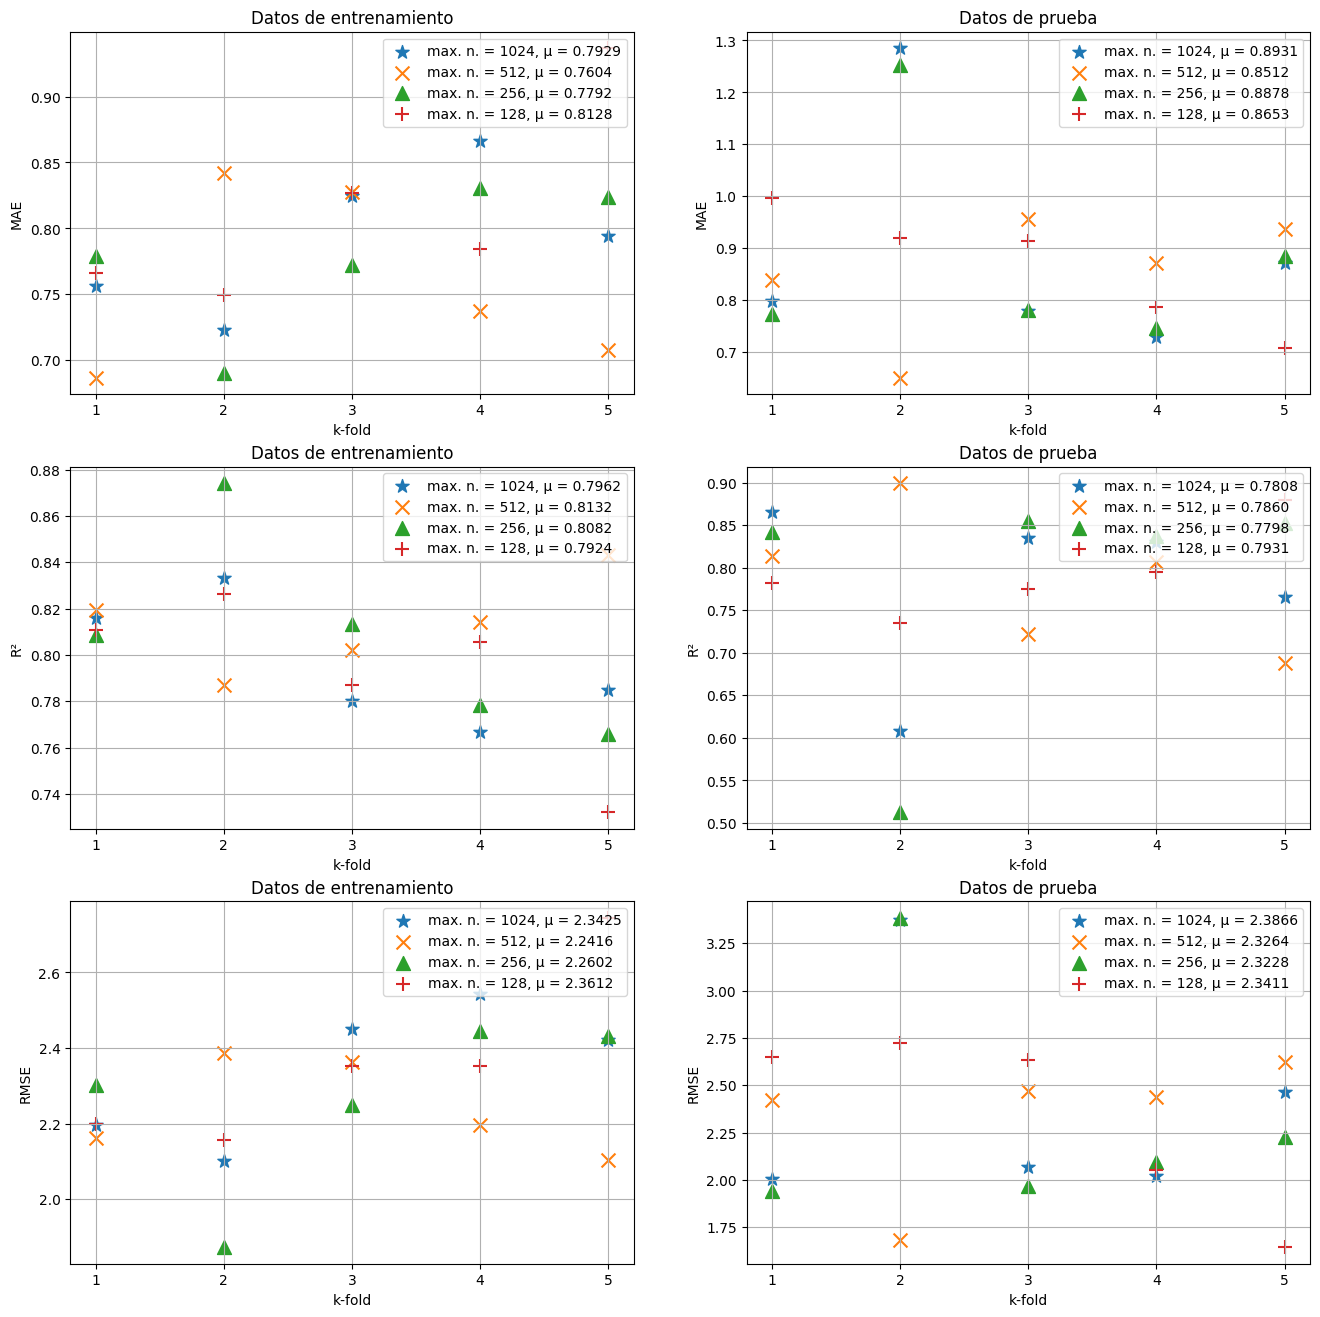

In [21]:
scores = [scores_1024_fiber_9, scores_512_fiber_9, scores_256_fiber_9, scores_128_fiber_9]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Usando los datos obtenidos mediante GKM

In [22]:
# Para leer los datos
data_file = "../BasesDeDatos/CaractGKM.csv"
df = pl.read_csv(data_file, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_B2B = df[0:987, :]
# Datos con fibra óptica a 0dBm
df_fiber_0 = df[988:1520, :]
# Datos con fibra óptica a 9dBm
df_fiber_9 = df[1521:, :]

## Crosvalidación para B2B variando el número de neuronas por capa

In [23]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_B2B = calc_once("scores_GKM_1024_B2B", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Iteraciones necesarias: 1385
7/7 [==============================] - 0s 2ms/step
Iteraciones necesarias: 4153
7/7 [==============================] - 0s 1ms/step
Iteraciones necesarias: 1335
7/7 [==============================] - 0s 1ms/step
Iteraciones necesarias: 2993
7/7 [==============================] - 0s 2ms/step
Iteraciones necesarias: 1091
7/7 [==============================] - 0s 1ms/step
Tiempo transcurrido: 12.23 minutos


In [24]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_B2B = calc_once("scores_GKM_512_B2B", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Iteraciones necesarias: 5000
7/7 [==============================] - 0s 2ms/step
Iteraciones necesarias: 2197
7/7 [==============================] - 0s 1ms/step
Iteraciones necesarias: 2785
7/7 [==============================] - 0s 3ms/step
Iteraciones necesarias: 2864
7/7 [==============================] - 0s 3ms/step
Iteraciones necesarias: 4254
7/7 [==============================] - 0s 3ms/step
Tiempo transcurrido: 13.80 minutos


In [25]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_B2B = calc_once("scores_GKM_256_B2B", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Iteraciones necesarias: 2428
7/7 [==============================] - 0s 3ms/step
Iteraciones necesarias: 3281
7/7 [==============================] - 0s 3ms/step
Iteraciones necesarias: 5000
7/7 [==============================] - 0s 3ms/step
Iteraciones necesarias: 5000
7/7 [==============================] - 0s 2ms/step
Iteraciones necesarias: 5000
7/7 [==============================] - 0s 2ms/step
Tiempo transcurrido: 14.28 minutos


In [26]:
args = {"data": df_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_B2B = calc_once("scores_GKM_128_B2B", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Iteraciones necesarias: 3383
7/7 [==============================] - 0s 3ms/step
Iteraciones necesarias: 5000
7/7 [==============================] - 0s 2ms/step
Iteraciones necesarias: 4209
7/7 [==============================] - 0s 2ms/step
Iteraciones necesarias: 2892
7/7 [==============================] - 0s 3ms/step
Iteraciones necesarias: 5000
7/7 [==============================] - 0s 2ms/step
Tiempo transcurrido: 11.43 minutos


In [38]:
%store scores_GKM_1024_B2B scores_GKM_512_B2B scores_GKM_256_B2B scores_GKM_128_B2B

Stored 'scores_GKM_1024_B2B' (dict)
Stored 'scores_GKM_512_B2B' (dict)
Stored 'scores_GKM_256_B2B' (dict)
Stored 'scores_GKM_128_B2B' (dict)


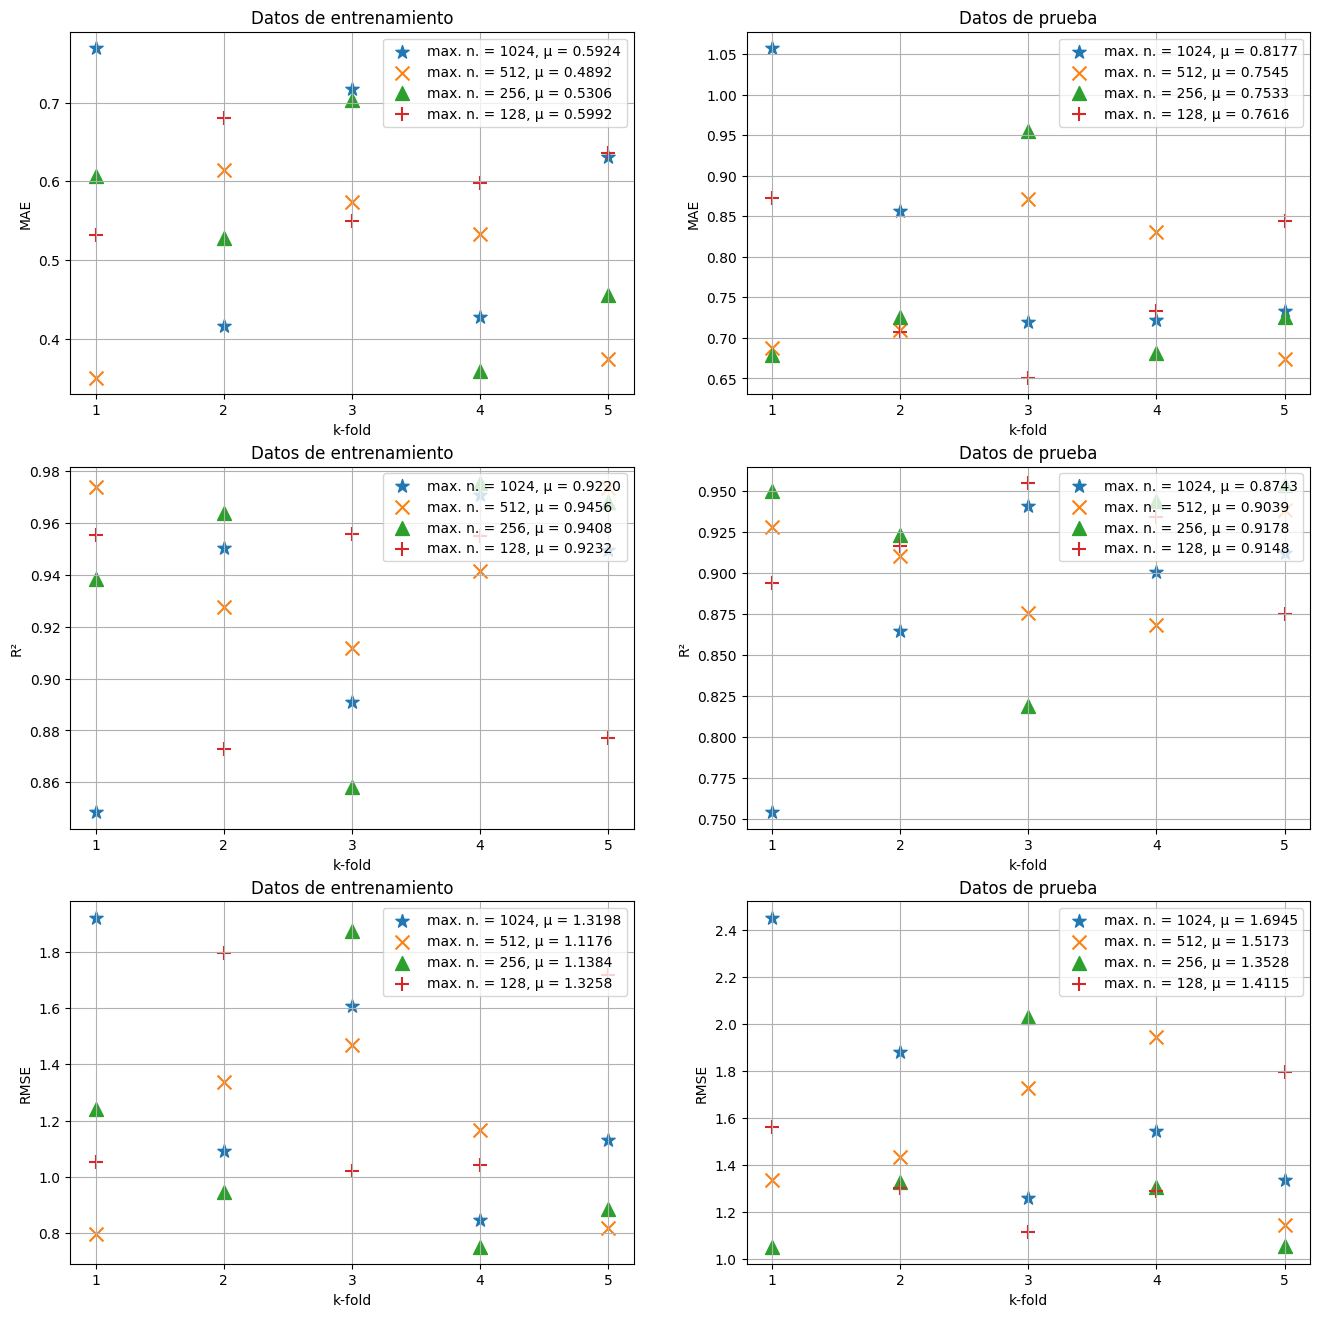

In [27]:
scores = [scores_GKM_1024_B2B, scores_GKM_512_B2B, scores_GKM_256_B2B, scores_GKM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Crosvalidación para fibra óptica a 0dBm variando el número de neuronas por capa

In [28]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber_0 = calc_once("scores_GKM_1024_fiber_0", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Iteraciones necesarias: 2068
4/4 [==============================] - 0s 4ms/step
Iteraciones necesarias: 2166
4/4 [==============================] - 0s 3ms/step
Iteraciones necesarias: 2510
4/4 [==============================] - 0s 4ms/step
Iteraciones necesarias: 4867
4/4 [==============================] - 0s 4ms/step
Iteraciones necesarias: 1718
4/4 [==============================] - 0s 4ms/step
Tiempo transcurrido: 16.06 minutos


In [29]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber_0 = calc_once("scores_GKM_512_fiber_0", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Iteraciones necesarias: 4708
4/4 [==============================] - 0s 3ms/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 3ms/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 1ms/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 1ms/step
Iteraciones necesarias: 4262
4/4 [==============================] - 0s 1ms/step
Tiempo transcurrido: 9.14 minutos


In [30]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber_0 = calc_once("scores_GKM_256_fiber_0", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Iteraciones necesarias: 3263
4/4 [==============================] - 0s 1ms/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 955us/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 1ms/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 959us/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 1ms/step
Tiempo transcurrido: 2.70 minutos


In [31]:
args = {"data": df_fiber_0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber_0 = calc_once("scores_GKM_128_fiber_0", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 1ms/step
Iteraciones necesarias: 2664
4/4 [==============================] - 0s 948us/step
Iteraciones necesarias: 5000
4/4 [==============================] - 0s 1ms/step
Iteraciones necesarias: 4725
4/4 [==============================] - 0s 866us/step
Iteraciones necesarias: 4722
4/4 [==============================] - 0s 904us/step
Tiempo transcurrido: 2.16 minutos


In [39]:
%store scores_GKM_1024_fiber_0 scores_GKM_512_fiber_0 scores_GKM_256_fiber_0 scores_GKM_128_fiber_0

Stored 'scores_GKM_1024_fiber_0' (dict)
Stored 'scores_GKM_512_fiber_0' (dict)
Stored 'scores_GKM_256_fiber_0' (dict)
Stored 'scores_GKM_128_fiber_0' (dict)


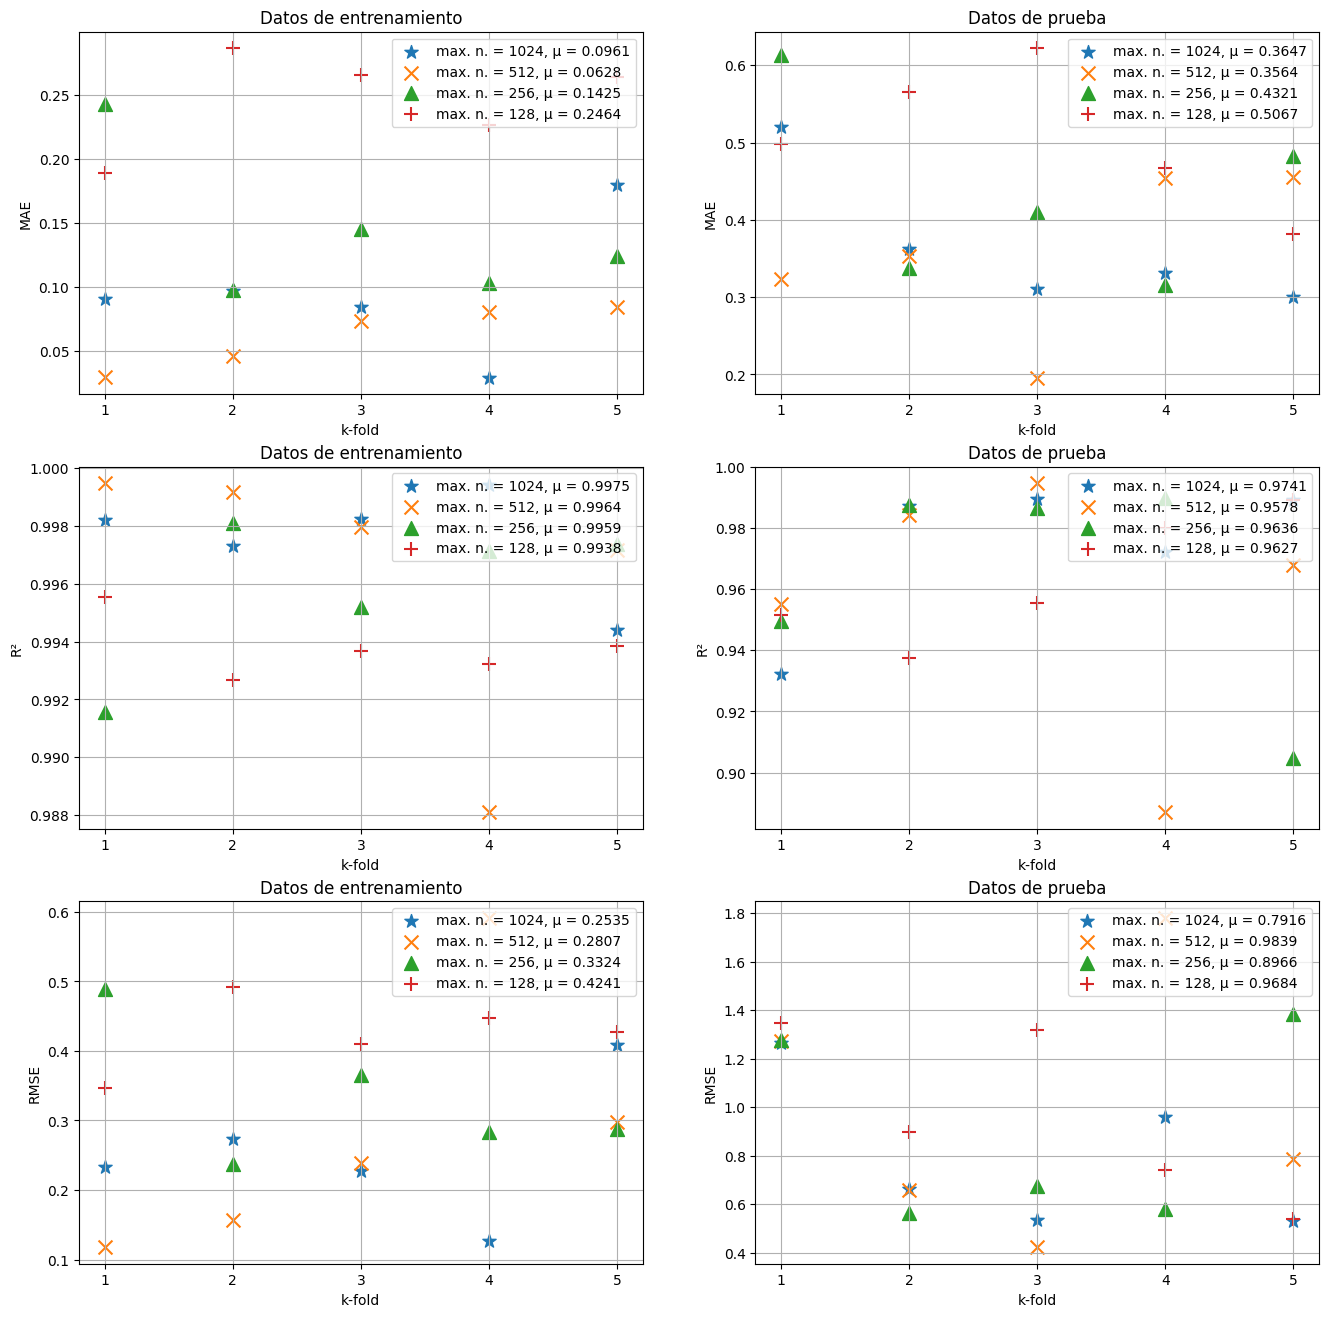

In [32]:
scores = [scores_GKM_1024_fiber_0, scores_GKM_512_fiber_0, scores_GKM_256_fiber_0, scores_GKM_128_fiber_0]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Crosvalidación para fibra óptica a 9dBm variando el número de neuronas por capa

In [33]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber_9 = calc_once("scores_GKM_1024_fiber_9", test_model, args)

[{'units': 1024, 'activation': 'relu'}, {'units': 512, 'activation': 'tanh'}, {'units': 256, 'activation': 'sigmoid'}]
Iteraciones necesarias: 1519
6/6 [==============================] - 0s 2ms/step
Iteraciones necesarias: 1691
6/6 [==============================] - 0s 2ms/step
Iteraciones necesarias: 1612
6/6 [==============================] - 0s 1ms/step
Iteraciones necesarias: 1374
6/6 [==============================] - 0s 2ms/step
Iteraciones necesarias: 1228
6/6 [==============================] - 0s 2ms/step
Tiempo transcurrido: 7.28 minutos


In [34]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber_9 = calc_once("scores_GKM_512_fiber_9", test_model, args)

[{'units': 512, 'activation': 'relu'}, {'units': 256, 'activation': 'tanh'}, {'units': 128, 'activation': 'sigmoid'}]
Iteraciones necesarias: 1340
6/6 [==============================] - 0s 999us/step
Iteraciones necesarias: 2149
6/6 [==============================] - 0s 1ms/step
Iteraciones necesarias: 1702
6/6 [==============================] - 0s 1ms/step
Iteraciones necesarias: 1571
6/6 [==============================] - 0s 967us/step
Iteraciones necesarias: 1373
6/6 [==============================] - 0s 1ms/step
Tiempo transcurrido: 2.86 minutos


In [35]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber_9 = calc_once("scores_GKM_256_fiber_9", test_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Iteraciones necesarias: 2575
6/6 [==============================] - 0s 903us/step
Iteraciones necesarias: 1515
6/6 [==============================] - 0s 953us/step
Iteraciones necesarias: 1137
6/6 [==============================] - 0s 803us/step
Iteraciones necesarias: 1323
6/6 [==============================] - 0s 957us/step
Iteraciones necesarias: 2322
6/6 [==============================] - 0s 840us/step
Tiempo transcurrido: 1.65 minutos


In [36]:
args = {"data": df_fiber_9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber_9 = calc_once("scores_GKM_128_fiber_9", test_model, args)

[{'units': 128, 'activation': 'relu'}, {'units': 64, 'activation': 'tanh'}, {'units': 32, 'activation': 'sigmoid'}]
Iteraciones necesarias: 1959
6/6 [==============================] - 0s 937us/step
Iteraciones necesarias: 1571
6/6 [==============================] - 0s 921us/step
Iteraciones necesarias: 1071
6/6 [==============================] - 0s 723us/step
Iteraciones necesarias: 2094
6/6 [==============================] - 0s 923us/step
Iteraciones necesarias: 2592
6/6 [==============================] - 0s 853us/step
Tiempo transcurrido: 1.44 minutos


In [40]:
%store scores_GKM_1024_fiber_9 scores_GKM_512_fiber_9 scores_GKM_256_fiber_9 scores_GKM_128_fiber_9

Stored 'scores_GKM_1024_fiber_9' (dict)
Stored 'scores_GKM_512_fiber_9' (dict)
Stored 'scores_GKM_256_fiber_9' (dict)
Stored 'scores_GKM_128_fiber_9' (dict)


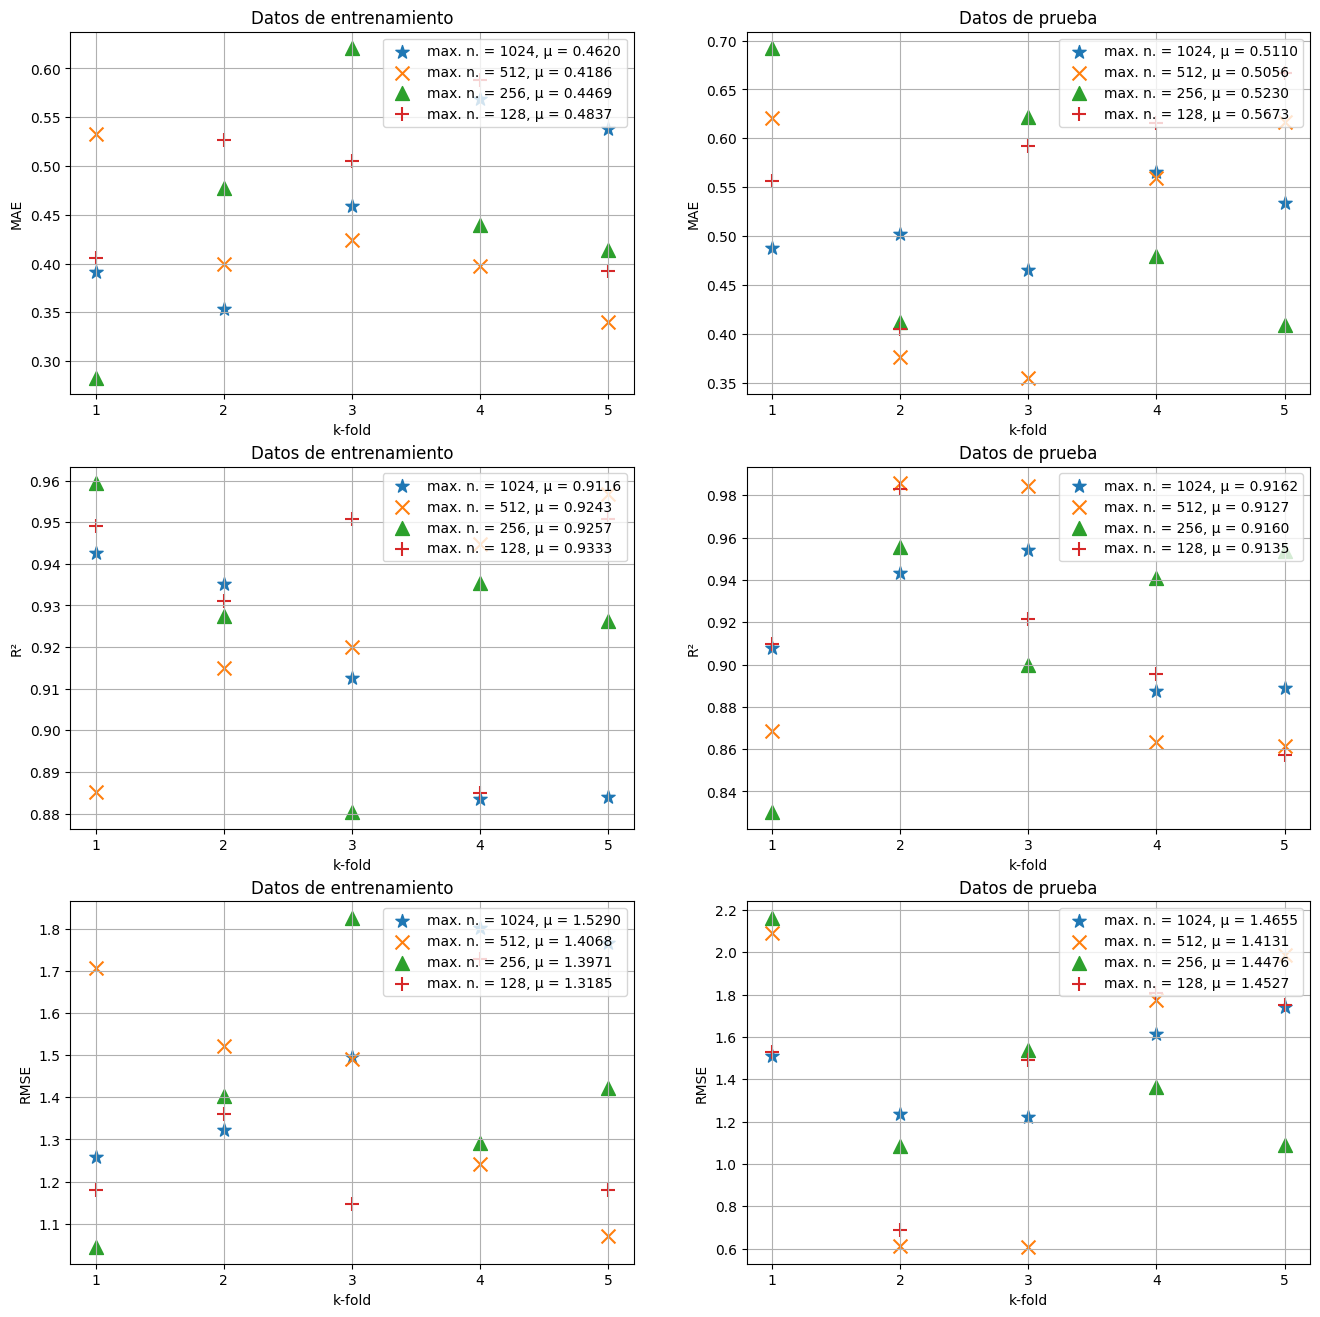

In [37]:
scores = [scores_GKM_1024_fiber_9, scores_GKM_512_fiber_9, scores_GKM_256_fiber_9, scores_GKM_128_fiber_9]
max_neurons = [1024, 512, 256, 128]
plot_scores(scores, max_neurons)

## Validación cruzada con los datos de Natalia
* Agregar la métrica de RMSE.
* Cambiar las gráficas para que se distingan por marcadores y solo con los puntos discretos.
* Probar con los datos GKM.
* Cambiar ReLu por Swish.""
* Variar el número de capas ocultas (1 a 4 capas (hard_sigmoid al inicio), (a menor número de capas se quitan las primeras funciones)).
* Variar las funciones de activación con el mejor resultado del número de neuronas.